**TFDWT version update** (apply patch)

---

Kishore Kumar Tarafdar, 20 June 2025

        Disable GPU: Force tensorflow to select CPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
import numpy as np

2025-06-23 13:39:06.536368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750666146.557425 1947577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750666146.563904 1947577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 13:39:06.587151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


        Select a GPU with a memory limit

In [4]:
# # include ../dirx 
mylibpath = [
    # '/home/kishor/src/FastDWTConvLayers',
    # '/home/kishor/src/MRSegmentation/Attentions19102023'
      # '/home/k/src/_MEDCNNsrc_part/MEDCNN_copy'
      '/home/kishoretarafdar/bin'
      # '/home/kishor/src/MEDCNN_copy'
    #'/home/k/PLAYGROUND10GB/SKULSTRIPpaper__'
    ]
import sys
[sys.path.insert(0,_) for _ in mylibpath]
del mylibpath

from tf_select_a_gpu import select_a_gpu
import tensorflow as tf

In [5]:
gpus = tf.config.list_physical_devices('GPU')
memory_limit = 30
select_a_gpu(gpus, gpu_id=2, memory_limit=memory_limit)
# del gpu_id, select_a_gpu, select_gpu

Virtual devices cannot be modified after being initialized


        GPU status...

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

len(gpus)

Num GPUs Available:  0


2025-06-19 22:19:17.415855: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-19 22:19:17.415970: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: meherangarh
2025-06-19 22:19:17.415980: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: meherangarh
2025-06-19 22:19:17.416277: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 570.148.8
2025-06-19 22:19:17.416335: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 570.148.8
2025-06-19 22:19:17.416342: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 570.148.8


0

# 1D

        MRA 1D layers
        TFDWT version update

In [ ]:
import tensorflow as tf
import keras
from TFDWT.GETDWTFiltersOrtho import GETDWTFiltersOrtho
from TFDWT.get_A_matrix_dwt_analysisFB_unit import get_A_matrix_dwt_analysisFB_unit

@keras.saving.register_keras_serializable()
class DWT1D(tf.keras.layers.Layer):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

    Note: if clean==True  then I/O (batch, N, channels) -> (batch, N/2, channels*2)
          if clean==False then I/O (batch, N, channels) -> (batch, N, channels)

    DWT1D layer  --kkt@20Jun2024"""
    def __init__(self, wave='haar', clean=True, **kwargs):
        super().__init__(**kwargs)
        self.wave = wave
        self.clean = clean  
        w = GETDWTFiltersOrtho(wave)
        self.h0, self.h1 = w.analysis()
        self.L = len(self.h0)
    
    def build(self, input_shape):
        self.N = input_shape[1]
        A = get_A_matrix_dwt_analysisFB_unit(self.h0,self.h1,self.N)
        self.A = tf.cast(tf.transpose(A, perm=[1,0]), tf.float32)

    def call(self, inputs):
        # inputs: (batch, N, channels)
        out = tf.einsum('bic,ij->bjc', inputs, self.A)
        if self.clean: return self.__extract_2subbands(out)
        else: return out

    def __extract_2subbands(self,LH_padded):
        """returns 2 subbands L, H from DWT Analysis bank o/p --@k"""
        mid = int(LH_padded.shape[1]/2)
        L = LH_padded[:,:mid,:]
        H = LH_padded[:,mid:,:]
        return tf.concat([L, H], axis=-1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'wave': self.wave,
            'clean': self.clean,
            # 'h0': list(self.h0),  # Converts TrackedList to regular list
            # add h1 if you also need it
            # 'h1': list(self.h1),
        })
        return config

In [ ]:
@keras.saving.register_keras_serializable()
class IDWT1D(tf.keras.layers.Layer):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.  
    

    Note: if clean==True  then I/O (batch, N/2, channels*2) -> (batch, N, channels)
          if clean==False then I/O (batch, N, channels) -> (batch, N, channels)  
    
    IDWT1D layer --kkt@20Jun2024"""
    def __init__(self, wave='haar', clean=True, **kwargs):
        super().__init__(**kwargs)
        self.wave = wave
        self.clean = clean
        w = GETDWTFiltersOrtho(wave)
        if 'bior' in wave or 'rbio' in wave:
            """BIORTHOGONAL wavelets"""
            self.h0, self.h1 = w.synthesis()
            # print(f"Biothogonal wavelet {wave}")
        else:
            """ORTHOGONAL wavelets"""
            self.h0, self.h1 = w.analysis()
        
        self.L = len(self.h0)

    def build(self, input_shape):
        if self.clean: self.N = int(input_shape[1] * 2)
        else: self.N = int(input_shape[1])
        A = get_A_matrix_dwt_analysisFB_unit(self.h0,self.h1,self.N)
        self.S = tf.cast(A, tf.float32)  # No transpose needed

    def call(self, inputs):
        # inputs: (batch, N, channels)
        if self.clean: inputs = self.__join_2subbands(inputs)
        out = tf.einsum('bic,ij->bjc', inputs, self.S)
        return out

    def __join_2subbands(self, concat_subbands):
        """
        Inverts tf.concat([L, H], axis=-1) where L, H have shape (batch, mid, channels).
        Returns (batch, 2*mid, channels).
        """
        L, H = tf.split(concat_subbands, 2, axis=-1)
        return tf.concat([L, H], axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'wave': self.wave,
            'clean': self.clean,
            # 'h0': list(self.h0),  # Converts TrackedList to regular list
            # add h1 if you also need it
            # 'h1': list(self.h1),
        })
        return config

wave = 'haar'
dwt_layer = DWT1D(wave)
idwt_layer = IDWT1D(wave)
# dwt_layer = DWT1D(wave, clean=False)
# idwt_layer = IDWT1D(wave,  clean=False)

x = tf.random.normal((2, 256, 1))  # batch=1, length=256, channels=2
lh = dwt_layer(x)
print('lh', lh.shape)
xhat = idwt_layer(lh)
print("DWT output shape:", lh.shape)
tf.reduce_max(tf.math.abs(x-xhat))

lh (2, 128, 2)
DWT output shape: (2, 128, 2)


2025-06-20 09:23:48.642747: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-20 09:23:48.642903: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: meherangarh
2025-06-20 09:23:48.642914: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: meherangarh
2025-06-20 09:23:48.643203: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 570.148.8
2025-06-20 09:23:48.643272: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 570.148.8
2025-06-20 09:23:48.643278: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 570.148.8


<tf.Tensor: shape=(), dtype=float32, numpy=2.384185791015625e-07>

In [4]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Example: Load or create a grayscale image (here, random for demo)
# Replace this with your actual image, e.g., arr = plt.imread("my_image.png")
arr = np.random.rand(128,)

# Compute level-1 DWT 2D using Haar wavelet
coeffs = pywt.dwt(arr, 'haar')

l, h = coeffs
l.shape, h.shape

((64,), (64,))

In [5]:
dwt_layer = DWT1D(wave)
# idwt_layer = IDWT2D(wave='haar')
# x = tf.random.normal((2, 256, 256, 1))  # batch=1, length=256, channels=2
x = tf.expand_dims(tf.expand_dims(arr, axis=-1), axis=0)
lh = dwt_layer(x)
# xhat = idwt_layer(lh)
print("DWT output shape:", lh.shape)
# tf.reduce_max(tf.math.abs(x-xhat))

DWT output shape: (1, 64, 2)


In [6]:
l1, h1 = [tf.squeeze(_) for _ in tf.unstack(lh, axis=-1)]
l.shape, h.shape
# plot(LL1, LH1, HL1, HH1)

((64,), (64,))

In [7]:
np.allclose(l, l1, rtol=0, atol=10**-5),  np.allclose(h, h1, rtol=0, atol=10**-5)
# tf.reduce_max(tf.math.abs(LL-LL1))

(True, True)

(<Axes: >,
 [<matplotlib.lines.Line2D at 0x7fd44068eab0>])

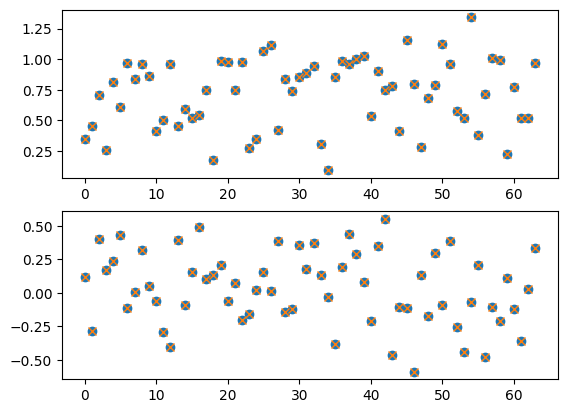

In [8]:
plt.subplot(211), plt.plot(l,'o'), plt.plot(l1, 'x')
plt.subplot(212), plt.plot(h,'o'), plt.plot(h1, 'x')

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# 2D

        MRA 2D layers
        TFDWT version update

In [ ]:
# from TFDWT.DWTIDWT2Dv1 import DWT2D as DWT2Dmother
# from TFDWT.DWTIDWT2Dv1 import IDWT2D as IDWT2Dmother
# from TFDWT.get_A_matrix_dwt_analysisFB_unit import get_A_matrix_dwt_analysisFB_unit
# import keras

import tensorflow as tf
import keras
from TFDWT.GETDWTFiltersOrtho import GETDWTFiltersOrtho
from TFDWT.get_A_matrix_dwt_analysisFB_unit import get_A_matrix_dwt_analysisFB_unit

@keras.saving.register_keras_serializable()
class DWT2D(tf.keras.layers.Layer):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
    Note: if clean==True  then I/O (batch, N, N, channels) -> (batch, N/2, N/2 channels*4)
          if clean==False then I/O (batch, N, N, channels) -> (batch, N, N, channels)

    DWT2D layer  --kkt@20Jun2024"""
    def __init__(self, wave='haar', clean=True, **kwargs):
        super().__init__(**kwargs)
        self.wave = wave
        self.clean = clean
        w = GETDWTFiltersOrtho(wave)
        self.h0, self.h1 = w.analysis()
        # g0, g1 = w.synthesis()
        self.L = len(self.h0)

    def build(self, input_shape):
        self.num_channels = input_shape[-1]
        self.N = input_shape[1]
        A = get_A_matrix_dwt_analysisFB_unit(self.h0,self.h1,self.N)
        # self.A = tf.transpose(self.A, perm=[1,0])
        self.A = tf.cast(A, tf.float32)  # (N, N)
       
    def call(self, inputs):
        # inputs: (batch, N, N, channels)
        
        # Step 1: Transpose for each channel (swap axes 1 and 2)
        x = tf.transpose(inputs, [0, 2, 1, 3])  # (batch, N, N, channels)

        # Step 2: Row convolution (A @ input) along the 2nd dimension
        x = tf.einsum('ij,bjkc->bikc', self.A, x)  # (batch, N, N, channels)

        # Step 3: Transpose back
        x = tf.transpose(x, [0, 2, 1, 3])  # (batch, N, N, channels)

        # Step 4: Column convolution (A @ input) along the 2nd dimension again
        x = tf.einsum('ij,bjkc->bikc', self.A, x)  # (batch, N, N, channels)

        if self.clean: return self.__extract_4subbands(x)
        else: return x
        #   # (batch, N, N, channels)

    def __extract_4subbands(self,LLLHHLHH):
        """returns 4 image subbands LL, LH, HL, HH from DWT Analysis bank o/p --@k"""
        # global N
        mid = int(LLLHHLHH.shape[1]/2)
        LL = LLLHHLHH[:, :mid, :mid, :]
        LH = LLLHHLHH[:, mid:, :mid, :]
        HL = LLLHHLHH[:, :mid, mid:, :]
        HH = LLLHHLHH[:, mid:, mid:, :]
        # _i = int((LL.shape[1] - self.N/2)/2)
        # out = tf.concat([LL[:,_i:-_i,_i:-_i,:], LH[:,_i:-_i,_i:-_i,:], HL[:,_i:-_i,_i:-_i,:], HH[:,_i:-_i,_i:-_i,:]], axis=-1)
        out = tf.concat([LL, LH, HL, HH], axis=-1)
        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            'wave': self.wave,
            'clean': self.clean,
            # 'h0': list(self.h0),  # Converts TrackedList to regular list
            # add h1 if you also need it
            # 'h1': list(self.h1),
        })
        return config
        


In [ ]:
@keras.saving.register_keras_serializable()
class IDWT2D(tf.keras.layers.Layer):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
    Note: if clean==True  then I/O (batch, N/2, N/2, channels*4) -> (batch, N, N channels)
          if clean==False then I/O (batch, N, N, channels) -> (batch, N, N, channels)

    IDWT2D layer --kkt@20Jun2024"""
    def __init__(self, wave='haar', clean=True, **kwargs):
        super().__init__(**kwargs)
        self.wave = wave
        self.clean = clean
        w = GETDWTFiltersOrtho(wave)
        if 'bior' in wave or 'rbio' in wave:
            """BIORTHOGONAL wavelets"""
            self.h0, self.h1 = w.synthesis()
            # print(f"Biothogonal wavelet {wave}")
        else:
            """ORTHOGONAL wavelets"""
            self.h0, self.h1 = w.analysis()
        # g0, g1 = w.synthesis()
        self.L = len(self.h0)
    
    def build(self, input_shape):
        # self.num_channels = input_shape[-1]
        # self.N = int(input_shape[1])
        if self.clean: self.N = int(input_shape[1]*2)
        else: self.N = int(input_shape[1])
        A = tf.cast(get_A_matrix_dwt_analysisFB_unit(self.h0,self.h1,self.N), tf.float32)
        self.S = tf.cast(tf.transpose(A), tf.float32)  # (N, N)

    def call(self, inputs):
        # inputs: (batch, N, N, channels)
        if self.clean: inputs = self.__join_quadrants(inputs)
        # Step 1: transpose N and N axes (1 and 2)
        x = tf.transpose(inputs, [0, 2, 1, 3])  # (batch, N, N, channels)
        # Step 2: matmul along axis 2 (columns after transpose)
        x = tf.einsum('ij,bjkc->bikc', self.S, x)
        # Step 3: transpose back
        x = tf.transpose(x, [0, 2, 1, 3])
        # Step 4: matmul along axis 2 again
        x = tf.einsum('ij,bjkc->bikc', self.S, x)
        return x

    def __join_quadrants(self, concat_quadrants):
        """
        Inverse of:
            LL = arr[:, :mid, :mid, :]
            LH = arr[:, mid:, :mid, :]
            HL = arr[:, :mid, mid:, :]
            HH = arr[:, mid:, mid:, :]
            out = tf.concat([LL, LH, HL, HH], axis=-1)
        """
        LL, LH, HL, HH = tf.split(concat_quadrants, num_or_size_splits=4, axis=-1)
        top = tf.concat([LL, HL], axis=2)     # [LL | HL]
        bottom = tf.concat([LH, HH], axis=2)  # [LH | HH]
        return tf.concat([top, bottom], axis=1)  # [top / bottom]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'wave': self.wave,
            'clean': self.clean,
            # 'h0': list(self.h0),  # Converts TrackedList to regular list
            # add h1 if you also need it
            # 'h1': list(self.h1),
        })
        return config
        

wave = 'haar'
dwt_layer = DWT2D(wave)
idwt_layer = IDWT2D(wave)
# dwt_layer = DWT2D(wave, clean=False)
# idwt_layer = IDWT2D(wave, clean=False)

# x = tf.random.normal((2, 256, 256, 5))  # batch=1, length=256, channels=2

#Example input 2
n = 256
axis1 = np.arange(0,n)
x = np.einsum('i,j->ij', axis1, axis1)
x = tf.cast(tf.expand_dims(tf.expand_dims(x,axis=-1), axis=0), tf.float32)
print('x', x.shape)
del axis1, n

## DWT
lh = dwt_layer(x)
print('lh', lh.shape)

# IDWT
xhat = idwt_layer(lh)
print("DWT output shape:", lh.shape)
tf.reduce_max(tf.math.abs(x-xhat))

x (1, 256, 256, 1)
lh (1, 128, 128, 4)
DWT output shape: (1, 128, 128, 4)


<tf.Tensor: shape=(), dtype=float32, numpy=0.015625>

In [17]:
np.allclose(x, xhat, rtol=0, atol=10**-5)

False

(<Axes: title={'center': '$x_r$'}>,
 Text(0.5, 1.0, '$x_r$'))

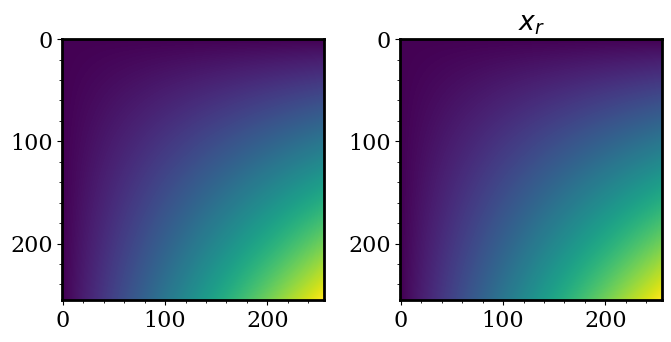

In [18]:
plt.figure(figsize=(7,4))
plt.subplot(121), plt.imshow(np.squeeze(x))
plt.subplot(122), plt.imshow(np.squeeze(xhat)), plt.title('$x_r$')

/tmp/ipykernel_662804/2344406764.py:19: RuntimeWarning: divide by zero encountered in divide
  rel_error = np.where(vals1 != 0, abs_error / np.abs(vals1), 0)


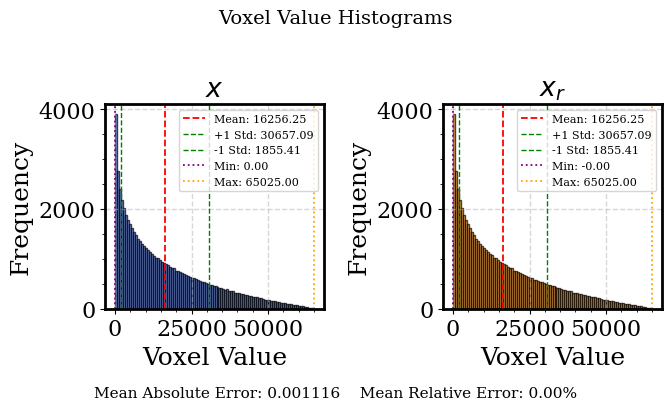

In [19]:
compare_hist(np.squeeze(x),np.squeeze(xhat))

LL shape: (128, 128)
LH shape: (128, 128)
HL shape: (128, 128)
HH shape: (128, 128)


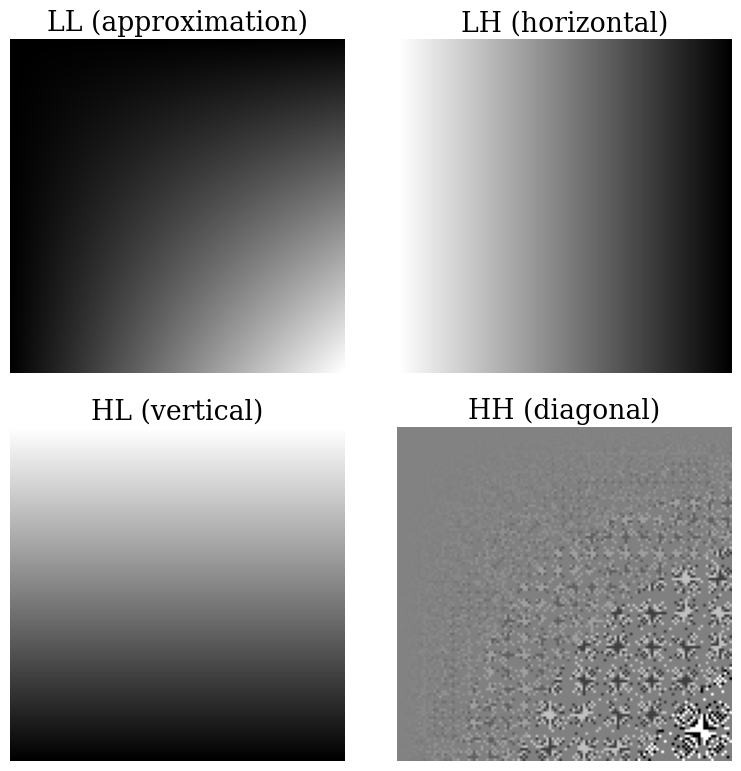

In [30]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Example: Load or create a grayscale image (here, random for demo)
# Replace this with your actual image, e.g., arr = plt.imread("my_image.png")
# arr = np.random.rand(128, 128)
arr = np.squeeze(x)
# Compute level-1 DWT 2D using Haar wavelet
coeffs2 = pywt.dwt2(arr,  wave)

LL, (LH, HL, HH) = coeffs2

def plot(LL, LH, HL, HH):
    print("LL shape:", LL.shape)
    print("LH shape:", LH.shape)
    print("HL shape:", HL.shape)
    print("HH shape:", HH.shape)

    # If you want to visualize the subbands:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(LL, cmap='gray')
    axs[0, 0].set_title('LL (approximation)')
    axs[0, 1].imshow(LH, cmap='gray')
    axs[0, 1].set_title('LH (horizontal)')
    axs[1, 0].imshow(HL, cmap='gray')
    axs[1, 0].set_title('HL (vertical)')
    axs[1, 1].imshow(HH, cmap='gray')
    axs[1, 1].set_title('HH (diagonal)')
    for ax in axs.ravel():
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plot(LL, LH, HL, HH)

In [31]:
# dwt_layer = DWT2D(wave='haar')
# # idwt_layer = IDWT2D(wave='haar')
# # x = tf.random.normal((2, 256, 256, 1))  # batch=1, length=256, channels=2
# x = tf.expand_dims(tf.expand_dims(arr, axis=-1), axis=0)
# lh = dwt_layer(x)
# xhat = idwt_layer(lh)
print("DWT output shape:", lh.shape)
# tf.reduce_max(tf.math.abs(x-xhat))

DWT output shape: (1, 128, 128, 4)


In [32]:
lh.shape

TensorShape([1, 128, 128, 4])

LL shape: (128, 128)
LH shape: (128, 128)
HL shape: (128, 128)
HH shape: (128, 128)


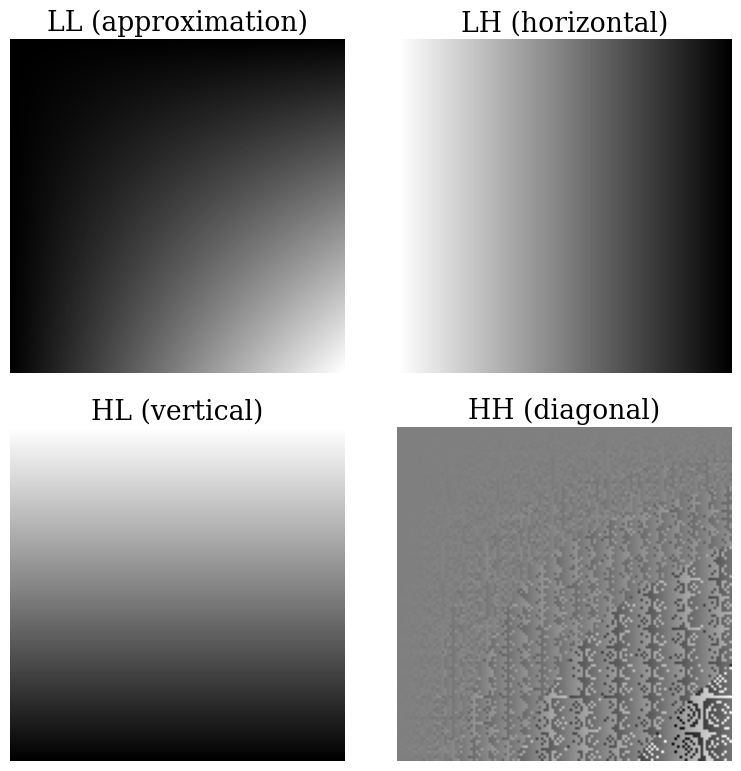

In [33]:
LL1, LH1, HL1, HH1 = [tf.squeeze(_) for _ in tf.unstack(lh, axis=-1)]

plot(LL1, LH1, HL1, HH1)

In [24]:
tf.reduce_max(tf.math.abs(LL-LL1))

NameError: name 'LL1' is not defined

In [167]:
[np.allclose(LL, LL1, rtol=0, atol=10**-5),
np.allclose(LH, LH1, rtol=0, atol=10**-5),
np.allclose(HL, HL1, rtol=0, atol=10**-5),
np.allclose(HH, HH1, rtol=0, atol=10**-5)]


[False, False, False, False]

In [172]:
# Perform inverse 3D DWT
reconstructed = pywt.idwt2(coeffs2, wavelet)

# Check reconstruction accuracy
error = np.max(np.abs(np.squeeze(x) - reconstructed))
print("Reconstruction error:", error)

Reconstruction error: 0.01171875


In [173]:
x.shape, reconstructed.shape

(TensorShape([1, 256, 256, 1]), (256, 256))

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# 3D

        MRA 3D layers
        TFDWT version update

In [3]:
import numpy as np

In [ ]:
# from TFDWT.DWTIDWT3Dv1 import DWT3D as DWT3Dmother
# from TFDWT.DWTIDWT3Dv1 import IDWT3D as IDWT3Dmother
# from TFDWT.get_A_matrix_dwt_analysisFB_unit import get_A_matrix_dwt_analysisFB_unit
# import keras


import tensorflow as tf
import keras
from TFDWT.GETDWTFiltersOrtho import GETDWTFiltersOrtho
from TFDWT.get_A_matrix_dwt_analysisFB_unit import get_A_matrix_dwt_analysisFB_unit

@keras.saving.register_keras_serializable()
class DWT3D(tf.keras.layers.Layer):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
    Note: if clean==True  then I/O (batch, N, N, N, channels) -> (batch, N/2, N/2, N/2, channels*8)
          if clean==False then I/O (batch, N, N, N, channels) -> (batch, N, N, N, channels)

    
    DWT3D layer  --kkt@20Jun2024"""
    
    def __init__(self, wave='haar', clean=True, **kwargs):
        super().__init__(**kwargs)
        self.wave = wave
        self.clean = clean
        w = GETDWTFiltersOrtho(wave)
        self.h0, self.h1 = w.analysis()
        self.L = len(self.h0)
        

    def build(self, input_shape):
        self.num_channels = input_shape[-1]
        self.N = input_shape[1]
        A = get_A_matrix_dwt_analysisFB_unit(self.h0,self.h1,self.N)
        self.A = tf.cast(A, tf.float32) 

    def call(self, inputs):
        # Inputs: (batch, row, col, depth, channel)
        A = self.A

        # Step 1: columns (axis 2)
        x = tf.transpose(inputs, [0, 2, 1, 3, 4])      # (batch, col, row, depth, ch)
        x = tf.einsum('ij,bjklc->biklc', A, x)         # apply S along columns
        x = tf.transpose(x, [0, 2, 1, 3, 4])           # (batch, row, col, depth, ch)

        # Step 2: rows (axis 1)
        x = tf.einsum('ij,bjklc->biklc', A, x)         # apply S along rows

        # Step 3: depth (axis 3)
        x = tf.transpose(x, [0, 3, 1, 2, 4])           # (batch, depth, row, col, ch)
        x = tf.einsum('ij,bjklc->biklc', A, x)         # apply S along depth
        x = tf.transpose(x, [0, 2, 3, 1, 4])           # back to (batch, row, col, depth, ch)
        if self.clean: return self.__extract_8subbands(x)
        else: return x

    def __extract_8subbands(self, LLLLLHLHLLHHHLLHLHHHLHHH):
        # arr shape: (batch, N, N, N, channels)
        mid = LLLLLHLHLLHHHLLHLHHHLHHH.shape[1] // 2

        LLL = LLLLLHLHLLHHHLLHLHHHLHHH[:, :mid, :mid, :mid, :]
        LLH = LLLLLHLHLLHHHLLHLHHHLHHH[:, :mid, :mid, mid:, :]
        LHL = LLLLLHLHLLHHHLLHLHHHLHHH[:, :mid, mid:, :mid, :]
        LHH = LLLLLHLHLLHHHLLHLHHHLHHH[:, :mid, mid:, mid:, :]

        HLL = LLLLLHLHLLHHHLLHLHHHLHHH[:, mid:, :mid, :mid, :]
        HLH = LLLLLHLHLLHHHLLHLHHHLHHH[:, mid:, :mid, mid:, :]
        HHL = LLLLLHLHLLHHHLLHLHHHLHHH[:, mid:, mid:, :mid, :]
        HHH = LLLLLHLHLLHHHLLHLHHHLHHH[:, mid:, mid:, mid:, :]

        return tf.concat([LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH], axis=-1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'wave': self.wave,
            'clean': self.clean,
            # 'h0': list(self.h0),  # Converts TrackedList to regular list
            # add h1 if you also need it
            # 'h1': list(self.h1),
        })
        return config

        


In [ ]:
@keras.saving.register_keras_serializable()
class IDWT3D(tf.keras.layers.Layer):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
       
    Note: if clean==True  then I/O (batch, N/2, N/2, N/2, channels*8) -> (batch, N, N, N, channels)
          if clean==False then I/O (batch, N, N, N, channels) -> (batch, N, N, N, channels)

    
    IDWT3D layer --kkt@20Jun2024"""
    def __init__(self, wave='haar', clean=True, **kwargs):
        super().__init__(**kwargs)
        self.wave = wave
        self.clean = clean
        w = GETDWTFiltersOrtho(wave)
        if 'bior' in wave or 'rbio' in wave:
            """BIORTHOGONAL wavelets"""
            self.h0, self.h1 = w.synthesis()
            print(f"Biothogonal wavelet {wave}")
        else:
            """ORTHOGONAL wavelets"""
            self.h0, self.h1 = w.analysis()
        self.L = len(self.h0)

    def build(self, input_shape):
        if self.clean: self.N = int(input_shape[1]*2)
        else: self.N = int(input_shape[1])
        A = get_A_matrix_dwt_analysisFB_unit(self.h0,self.h1,self.N)
        self.S = tf.cast(tf.transpose(A), tf.float32)  # (N, N)
    
    def call(self, inputs):
        # Inputs: (batch, row, col, depth, channel)
        if self.clean: inputs = self.__join_octants(inputs)
        # S = self.S
        # Step 1: columns (axis 2)
        x = tf.transpose(inputs, [0, 2, 1, 3, 4])      # (batch, col, row, depth, ch)
        x = tf.einsum('ij,bjklc->biklc', self.S, x)         # apply S along columns
        x = tf.transpose(x, [0, 2, 1, 3, 4])           # (batch, row, col, depth, ch)

        # Step 2: rows (axis 1)
        x = tf.einsum('ij,bjklc->biklc', self.S, x)         # apply S along rows

        # Step 3: depth (axis 3)
        x = tf.transpose(x, [0, 3, 1, 2, 4])           # (batch, depth, row, col, ch)
        x = tf.einsum('ij,bjklc->biklc', self.S, x)         # apply S along depth
        x = tf.transpose(x, [0, 2, 3, 1, 4])           # back to (batch, row, col, depth, ch)
        return x

    def __join_octants(self, concat_octants):
        # concat_octants: shape (batch, mid, mid, mid, channels*8)
        batch, mid, _, _, total_channels = concat_octants.shape.as_list()
        channels = total_channels // 8

        # Split along channel axis
        octants = tf.split(concat_octants, num_or_size_splits=8, axis=-1)
        LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH = octants

        # Stack along depth (axis=3)
        front_top = tf.concat([LLL, LLH], axis=3)
        front_bot = tf.concat([LHL, LHH], axis=3)
        back_top  = tf.concat([HLL, HLH], axis=3)
        back_bot  = tf.concat([HHL, HHH], axis=3)

        # Stack along columns (axis=2)
        front = tf.concat([front_top, front_bot], axis=2)
        back = tf.concat([back_top, back_bot], axis=2)

        # Stack along rows (axis=1)
        arr = tf.concat([front, back], axis=1)

        return arr  # shape: (batch, N, N, N, channels)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'wave': self.wave,
            'clean': self.clean,
            # 'h0': list(self.h0),  # Converts TrackedList to regular list
            # add h1 if you also need it
            # 'h1': list(self.h1),
        })
        return config

    
wavelet = 'bior1.5'
# dwt_layer = DWT3D(wave=wavelet)
# idwt_layer = IDWT3D(wave=wavelet)
dwt_layer = DWT3D(wave=wavelet, clean=False)
idwt_layer = IDWT3D(wave=wavelet, clean=False)

##Example input 1
# x = tf.random.normal((1, 256, 256, 256, 2))  # batch=1, length=256, channels=2

#Example input 2
n = 256
axis1 = np.arange(0,n)
x = np.einsum('i,j->ij', axis1, axis1)
x = np.einsum('i,j,k->ijk', axis1, axis1, axis1)
x = tf.cast(tf.expand_dims(tf.expand_dims(x,axis=-1), axis=0), tf.float32)
del axis1, n

## DWT
lh = dwt_layer(x)
print('lh', lh.shape)

## IDWT
xhat = idwt_layer(lh)
print("DWT output shape:", lh.shape)
print("Max reconstruction error", tf.reduce_max(tf.math.abs(x-xhat)).numpy())

Biothogonal wavelet bior1.5


2025-06-20 09:12:01.943341: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-20 09:12:01.943454: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: meherangarh
2025-06-20 09:12:01.943462: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: meherangarh
2025-06-20 09:12:01.943665: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 570.148.8
2025-06-20 09:12:01.943719: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 570.148.8
2025-06-20 09:12:01.943725: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 570.148.8


lh (1, 256, 256, 256, 1)
DWT output shape: (1, 256, 256, 256, 1)
Max reconstruction error 8.0


In [6]:
np.allclose(x, xhat, rtol=0, atol=10**-5)

False

    comparing voxels to verify perfect reconstruction

/tmp/ipykernel_661928/2344406764.py:19: RuntimeWarning: divide by zero encountered in divide
  rel_error = np.where(vals1 != 0, abs_error / np.abs(vals1), 0)


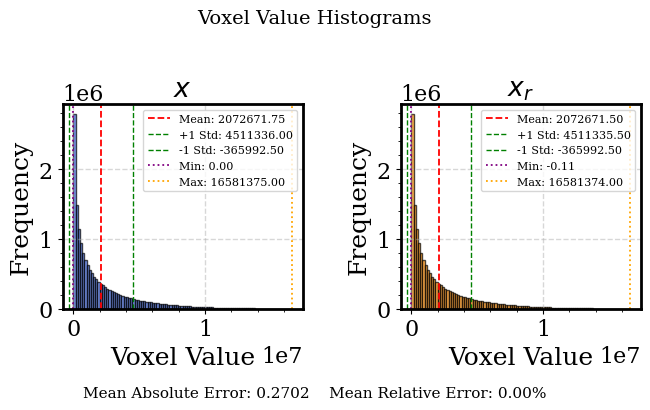

In [10]:
compare_hist(np.squeeze(x),np.squeeze(xhat))

Volume range: 0.000 to 16581375.000 — using level=8290687.500
Volume range: -0.110 to 16581374.000 — using level=8290687.000


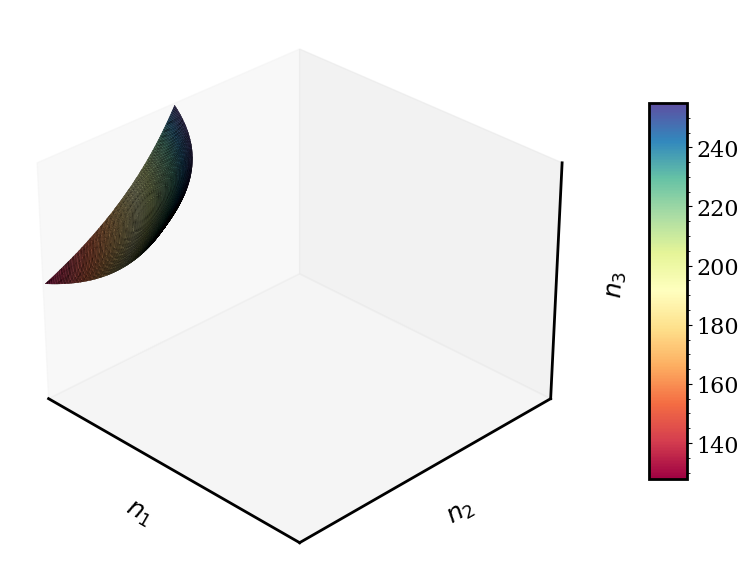

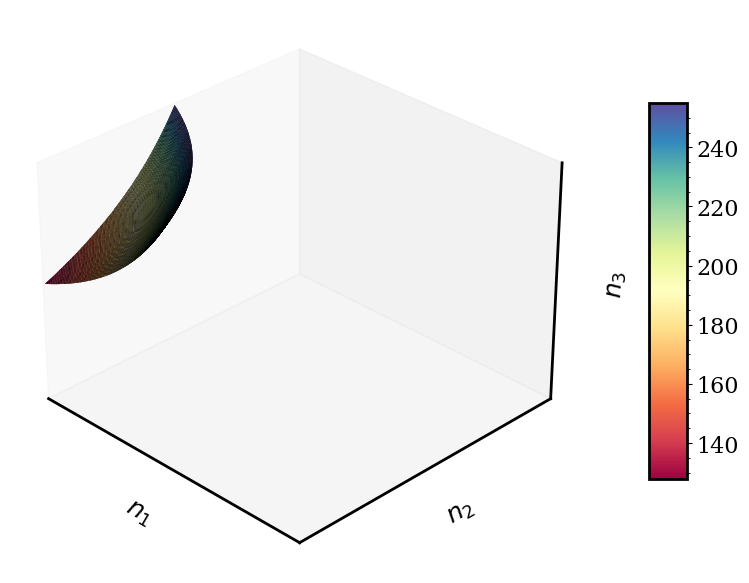

In [28]:
viz(tf.squeeze(x).numpy())
viz(tf.squeeze(xhat).numpy())

In [50]:
# viz(tf.squeeze(x[0,...]).numpy()), viz(tf.squeeze(xhat[0,...]).numpy())

In [42]:
x.shape

TensorShape([1, 256, 256, 256, 1])

In [43]:
whos

Variable                           Type           Data/Info
-----------------------------------------------------------
DWT3D                              type           <class '__main__.DWT3D'>
DWT3Dmother                        type           <class 'TFDWT.DWTIDWT3Dv1.DWT3D'>
IDWT3D                             type           <class '__main__.IDWT3D'>
IDWT3Dmother                       type           <class 'TFDWT.DWTIDWT3Dv1.IDWT3D'>
Poly3DCollection                   type           <class 'mpl_toolkits.mplo<...>.art3d.Poly3DCollection'>
aaa                                ndarray        1x128x128x256: 4194304 elems, type `float32`, 16777216 bytes (16.0 Mb)
aaa1                               EagerTensor    tf.Tensor(\n[[[3.5355335e<...>128, 128), dtype=float32)
aad                                ndarray        1x128x128x256: 4194304 elems, type `float32`, 16777216 bytes (16.0 Mb)
aad1                               EagerTensor    tf.Tensor(\n[[[-3.5355335<...>128, 128), dtype=float32)


        compare with PyWavelets

In [70]:
import numpy as np
import pywt

# Generate a random 3D array (e.g., shape 8x8x8)
# x3 = np.random.rand(8, 8, 8)
x3 = tf.squeeze(x)

# Choose a wavelet (e.g., 'db1' = Daubechies 1 / Haar)
# wavelet = 'db4'

# Perform single-level 3D DWT
coeffs = pywt.dwtn(x3, wavelet, axes=(0, 1, 2))

# Unpack all subbands into variables
aaa = coeffs['aaa']
aad = coeffs['aad']
ada = coeffs['ada']
add = coeffs['add']
daa = coeffs['daa']
dad = coeffs['dad']
dda = coeffs['dda']
ddd = coeffs['ddd']
# coeffs is a dictionary with keys like:
# 'aaa' (approximation), 'aad', 'ada', ..., 'ddd' (detail coefficients)
for key, value in coeffs.items():
    print(f"{key}: shape = {value.shape}")


aaa: shape = (128, 128, 128)
aad: shape = (128, 128, 128)
ada: shape = (128, 128, 128)
add: shape = (128, 128, 128)
daa: shape = (128, 128, 128)
dad: shape = (128, 128, 128)
dda: shape = (128, 128, 128)
ddd: shape = (128, 128, 128)


In [71]:
# Perform inverse 3D DWT
reconstructed = pywt.idwtn(coeffs, wavelet, axes=(0, 1, 2))

# Check reconstruction accuracy
error = np.max(np.abs(x3 - reconstructed))
print("Reconstruction error:", error)

Reconstruction error: 1.1920929e-06


        compare with layer output

In [ ]:
aaa1, aad1, ada1, add1, daa1, dad1, dda1, ddd1 = [tf.squeeze(_) for _ in tf.unstack(lh, axis=-1)]

In [73]:
[
    np.allclose(aaa, aaa1, rtol=0, atol=10**-5),
    np.allclose(aad, aad1, rtol=0, atol=10**-5),
    np.allclose(ada, ada1, rtol=0, atol=10**-5),
    np.allclose(add, add1, rtol=0, atol=10**-5),
    np.allclose(daa, daa1, rtol=0, atol=10**-5),
    np.allclose(dad, dad1, rtol=0, atol=10**-5),
    np.allclose(dda, dda1, rtol=0, atol=10**-5),
    np.allclose(ddd, ddd1, rtol=0, atol=10**-5)
]

[True, True, True, True, True, True, True, True]

In [74]:
# compare_hist(aaa, aaa1.numpy())
# compare_hist(aad, aaa1.numpy())
# compare_hist(ddd, ddd1.numpy())

In [84]:
# viz(aad)
# viz(add) #
# viz(daa)
# viz(dad)
# viz(dda)

In [25]:
# viz(daa1.numpy()) #aad
# viz(dda1.numpy()) #add
# viz(aad1.numpy()) #daa
# viz(dad1.numpy()) #dad
# viz(add1.numpy()) #dda




Volume range: 0.354 to 46623872.000 — using level=23311936.000
Volume range: 0.354 to 46623872.000 — using level=23311936.000
Volume range: -91602.000 to -0.354 — using level=-45801.176
Volume range: -91600.781 to -0.354 — using level=-45800.566
Volume range: -91600.734 to -0.354 — using level=-45800.543
Volume range: -91599.562 to -0.354 — using level=-45799.957
Volume range: 0.351 to 182.434 — using level=91.392
Volume range: 0.352 to 180.789 — using level=90.571
Volume range: -91600.000 to -0.354 — using level=-45800.176
Volume range: -91600.297 to -0.354 — using level=-45800.324
Volume range: 0.352 to 181.004 — using level=90.678
Volume range: 0.350 to 182.339 — using level=91.345
Volume range: 0.352 to 181.000 — using level=90.676
Volume range: 0.352 to 180.792 — using level=90.572
Volume range: -2.001 to 1.001 — using level=-0.500
Volume range: -1.241 to 0.521 — using level=-0.360


(None, None)

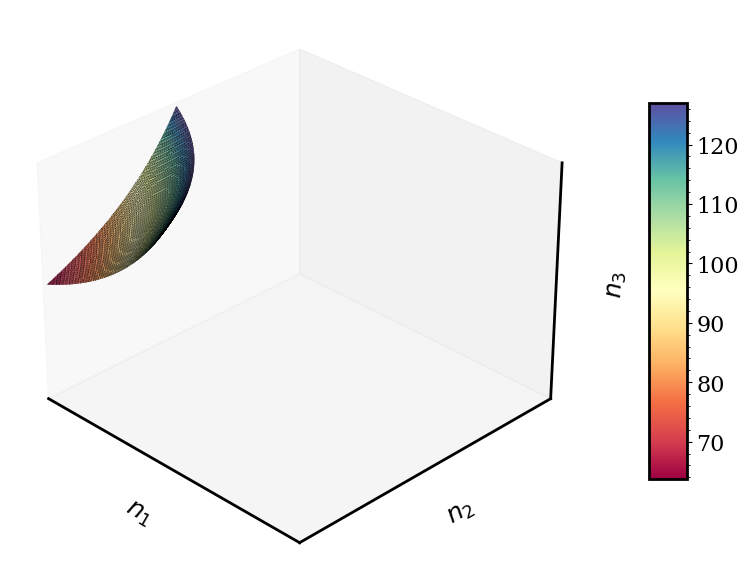

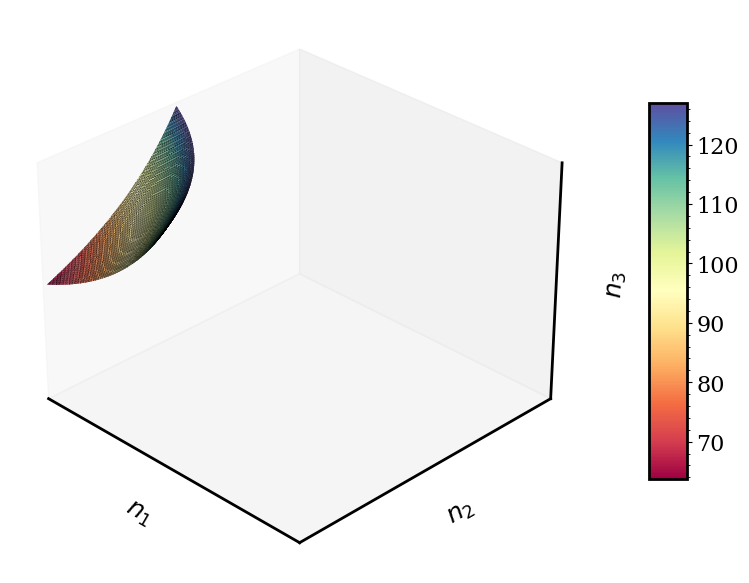

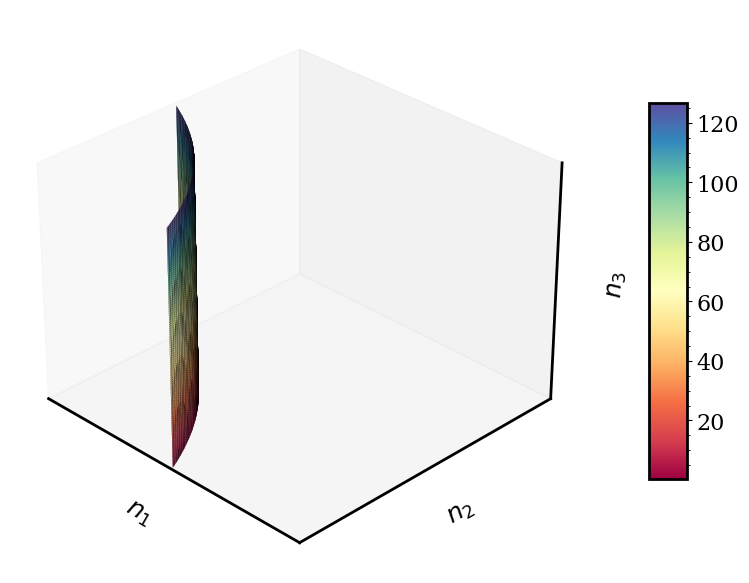

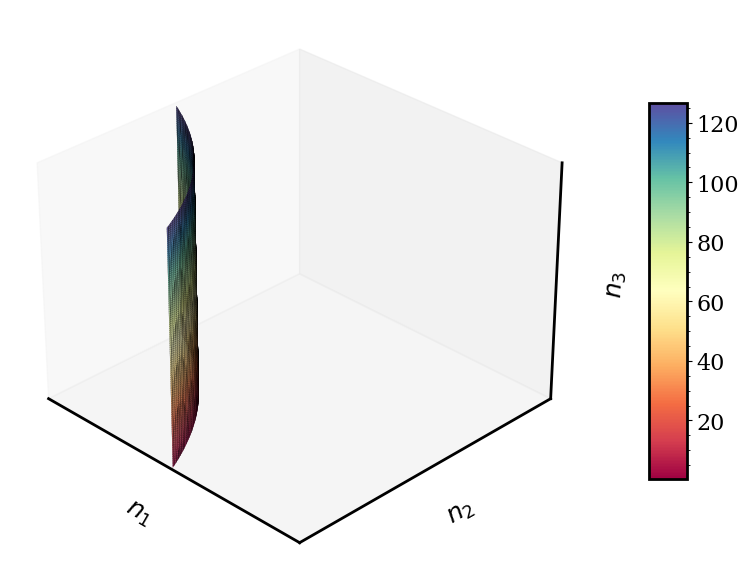

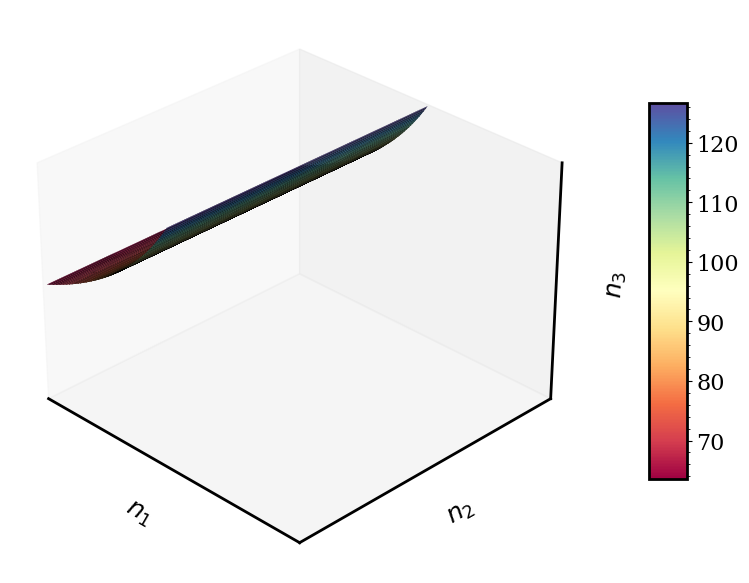

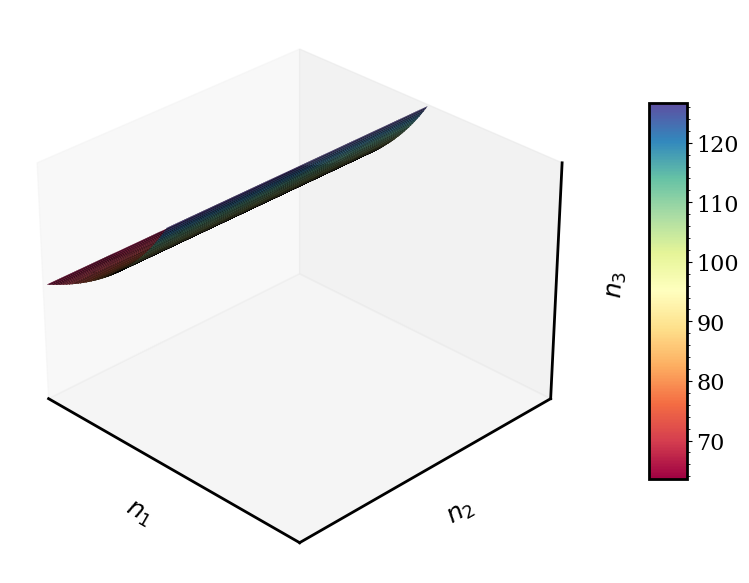

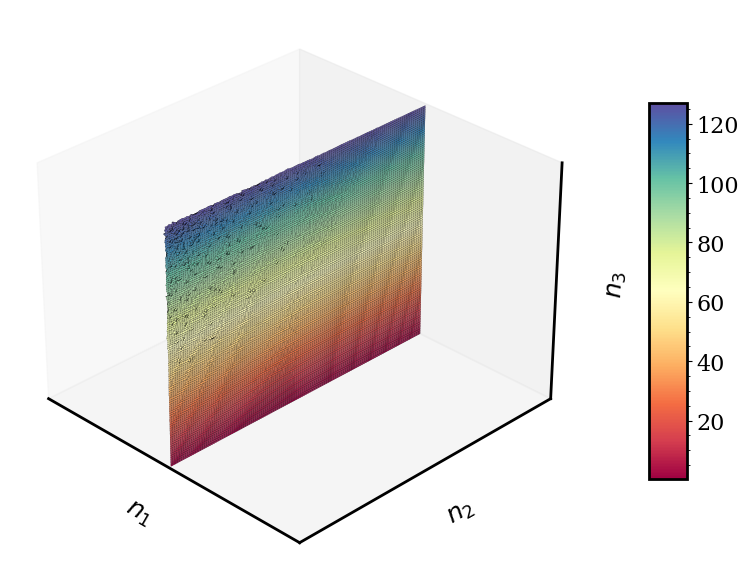

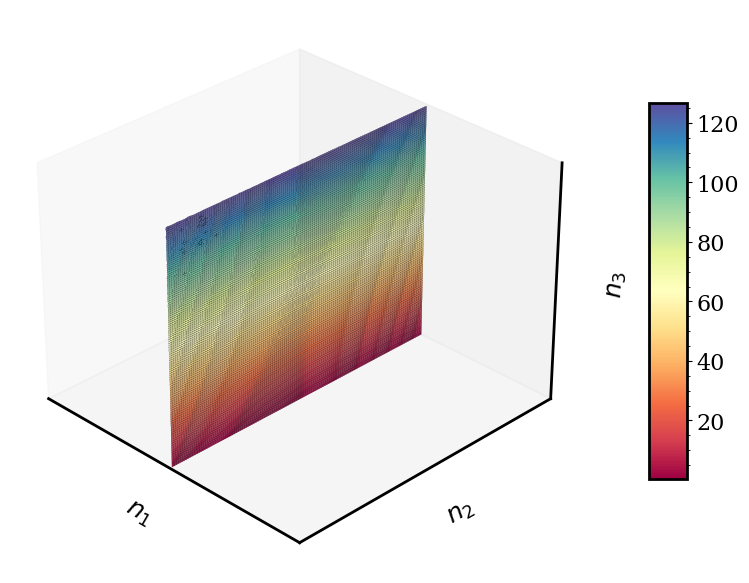

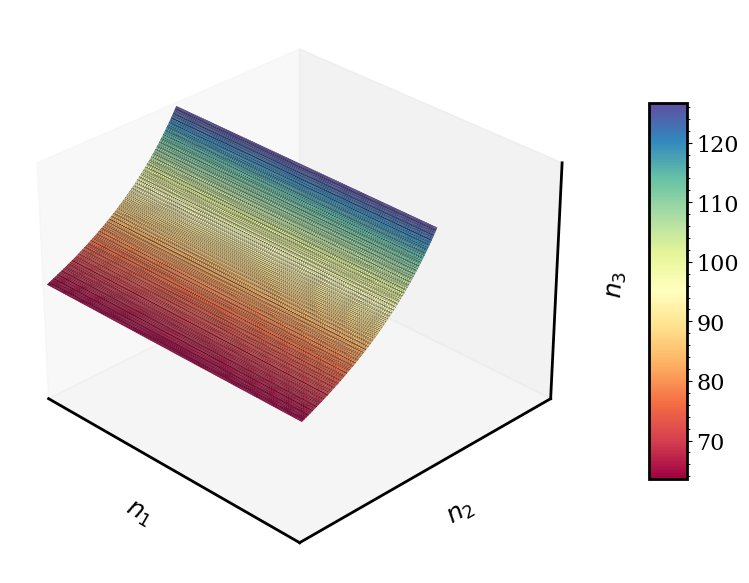

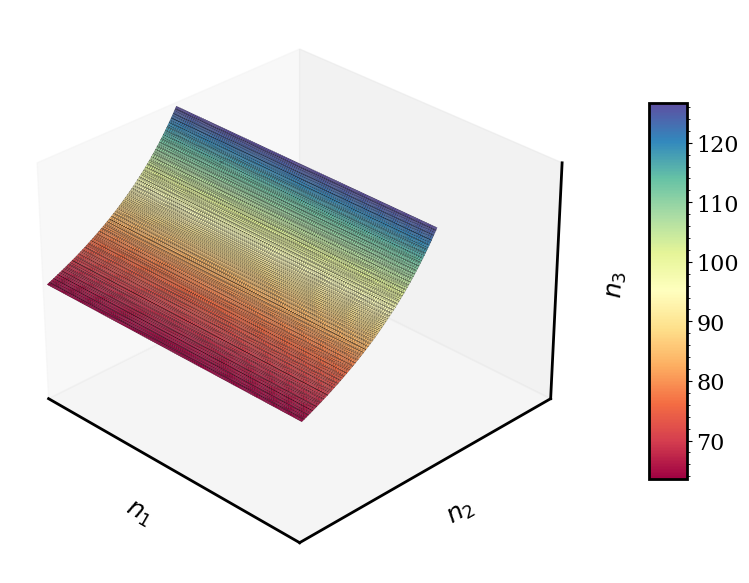

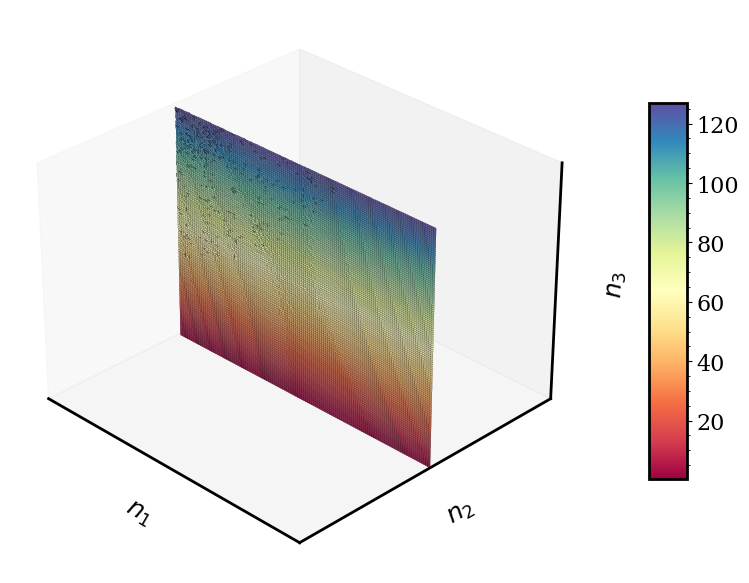

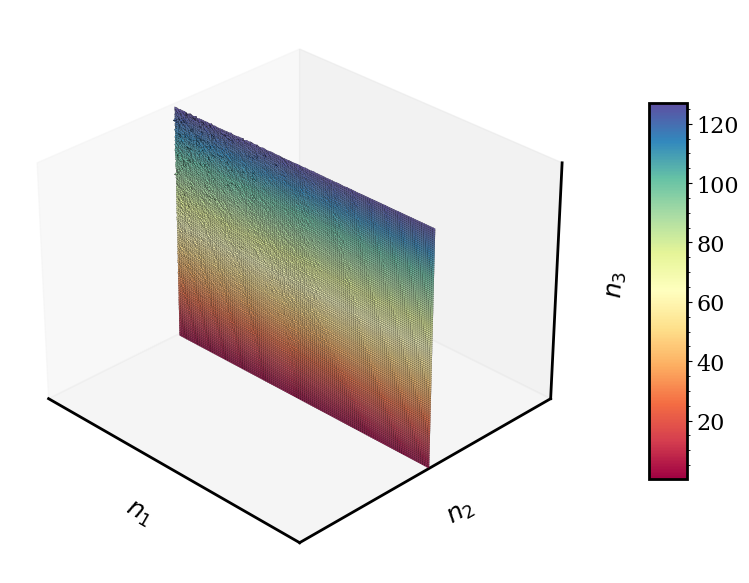

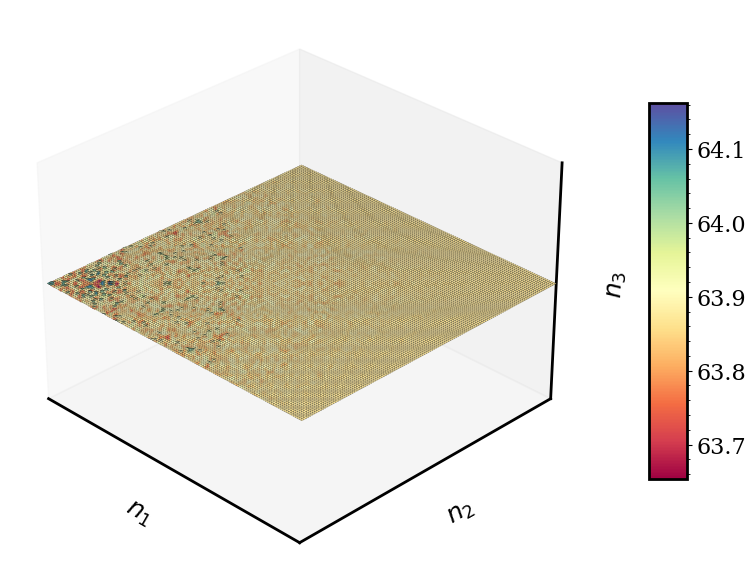

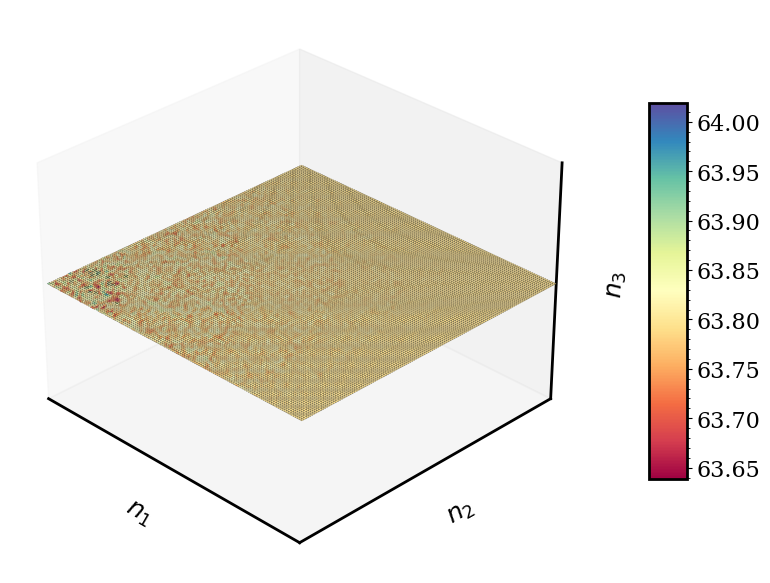

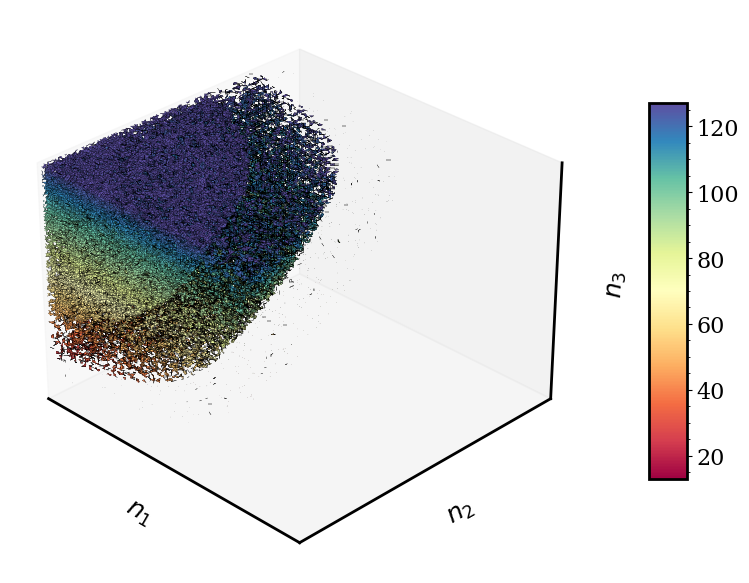

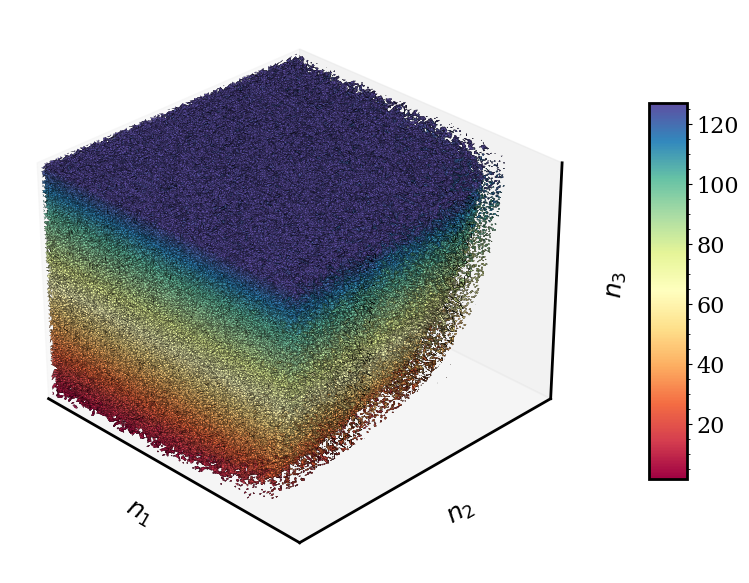

In [66]:
viz(aaa), viz(aaa1.numpy())# ok
viz(aad), viz(aad1.numpy())
viz(ada), viz(ada1.numpy()) # ok
viz(add), viz(add1.numpy())
viz(daa), viz(daa1.numpy())
viz(dad), viz(dad1.numpy())
viz(dda), viz(dda1.numpy())
viz(ddd), viz(ddd1.numpy())

In [9]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

# Set rcParams for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 9)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['axes.linewidth'] = 2.0  
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 16

def viz(volume, level=None, elev=30, azim=135, colormap=cm.Spectral):
    L = volume.shape[1]
    min_val = np.min(volume)
    max_val = np.max(volume)
    if level is None:
        level = (min_val + max_val) * 0.5

    print(f"Volume range: {min_val:.3f} to {max_val:.3f} — using level={level:.3f}")

    # Extract mesh with marching cubes
    verts, faces, _, _ = measure.marching_cubes(volume, level=level)
    face_colors = verts[faces][:, :, 2].mean(axis=1)
    norm = (face_colors - face_colors.min()) / (np.ptp(face_colors) + 1e-8)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], facecolors=colormap(norm), edgecolor='k', linewidths=0.1, alpha=1.0)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    ax.set_xlabel('$n_1$')
    ax.set_ylabel('$n_2$')
    ax.set_zlabel('$n_3$')

    ax.view_init(elev=elev, azim=azim)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(False)
    plt.tight_layout()

    # Optional: add colorbar
    mappable = cm.ScalarMappable(cmap=colormap)
    mappable.set_array(face_colors)
    plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, pad=0.1)

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# def plothist(voxels):
#     # Flatten the 3D array to 1D for histogram
#     voxel_values = voxels.flatten()

#     # Plot histogram
#     plt.figure(figsize=(8, 5))
#     n, bins, patches = plt.hist(voxel_values, bins=100, color='royalblue', alpha=0.75, edgecolor='black')

#     mean = np.mean(voxel_values)
#     std = np.std(voxel_values)
#     vmin = np.min(voxel_values)
#     vmax = np.max(voxel_values)

#     plt.title('Histogram of Voxel Intensities')
#     plt.xlabel('Voxel Value')
#     plt.ylabel('Frequency')
#     plt.grid(True, linestyle='--', alpha=0.5)
#     plt.tight_layout()

#     # Add summary statistics
#     plt.axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.2f}')
#     plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'+1 Std: {mean+std:.2f}')
#     plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1, label=f'-1 Std: {mean-std:.2f}')
#     plt.axvline(vmin, color='purple', linestyle='dotted', linewidth=1.5, label=f'Min: {vmin:.2f}')
#     plt.axvline(vmax, color='orange', linestyle='dotted', linewidth=1.5, label=f'Max: {vmax:.2f}')
#     plt.legend()

#     # plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def compare_hist(voxels1, voxels2, bins=100, title1="$x$", title2="$x_r$"):
    vals1 = voxels1.flatten()
    vals2 = voxels2.flatten()
    vmin = min(vals1.min(), vals2.min())
    vmax = max(vals1.max(), vals2.max())
    bins = np.linspace(vmin, vmax, bins + 1)

    mean1, std1 = vals1.mean(), vals1.std()
    mean2, std2 = vals2.mean(), vals2.std()
    min1, max1 = vals1.min(), vals1.max()
    min2, max2 = vals2.min(), vals2.max()

    # Error statistics
    if vals1.shape == vals2.shape:
        abs_error = np.abs(vals1 - vals2)
        rel_error = np.where(vals1 != 0, abs_error / np.abs(vals1), 0)
        mae = abs_error.mean()
        mre = rel_error.mean() * 100
        error_str = f"Mean Absolute Error: {mae:.4g}    Mean Relative Error: {mre:.2f}%"
    else:
        error_str = ""

    fig, axs = plt.subplots(1, 2, figsize=(7, 4))

    axs[0].hist(vals1, bins=bins, color='royalblue', alpha=0.7, edgecolor='black')
    axs[0].set_title(title1)
    axs[0].set_xlabel('Voxel Value')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True, linestyle='--', alpha=0.5)
    axs[0].axvline(mean1, color='red', linestyle='dashed', linewidth=1.3, label=f'Mean: {mean1:.2f}')
    axs[0].axvline(mean1 + std1, color='green', linestyle='dashed', linewidth=1, label=f'+1 Std: {mean1 + std1:.2f}')
    axs[0].axvline(mean1 - std1, color='green', linestyle='dashed', linewidth=1, label=f'-1 Std: {mean1 - std1:.2f}')
    axs[0].axvline(min1, color='purple', linestyle='dotted', linewidth=1.3, label=f'Min: {min1:.2f}')
    axs[0].axvline(max1, color='orange', linestyle='dotted', linewidth=1.3, label=f'Max: {max1:.2f}')
    axs[0].legend(fontsize=8)

    axs[1].hist(vals2, bins=bins, color='darkorange', alpha=0.7, edgecolor='black')
    axs[1].set_title(title2)
    axs[1].set_xlabel('Voxel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True, linestyle='--', alpha=0.5)
    axs[1].axvline(mean2, color='red', linestyle='dashed', linewidth=1.3, label=f'Mean: {mean2:.2f}')
    axs[1].axvline(mean2 + std2, color='green', linestyle='dashed', linewidth=1, label=f'+1 Std: {mean2 + std2:.2f}')
    axs[1].axvline(mean2 - std2, color='green', linestyle='dashed', linewidth=1, label=f'-1 Std: {mean2 - std2:.2f}')
    axs[1].axvline(min2, color='purple', linestyle='dotted', linewidth=1.3, label=f'Min: {min2:.2f}')
    axs[1].axvline(max2, color='orange', linestyle='dotted', linewidth=1.3, label=f'Max: {max2:.2f}')
    axs[1].legend(fontsize=8)

    plt.suptitle("Voxel Value Histograms", fontsize=14)
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])  # Leave space at the bottom

    # Place error summary below plots, outside axes
    fig.text(0.5, 0.01, error_str, ha="center", fontsize=11,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

In [179]:
import tensorflow as tf

@tf.function
def make_dwt_operator_matrix_A_ta(h0, h1, N: int):
    """
    Returns DWT operator matrix A built from h0, h1 filters for signal of length N.
    Uses TensorArray to construct the row-shifted convolution matrices.
    """
    h0 = tf.convert_to_tensor(h0, dtype=tf.float32)
    h1 = tf.convert_to_tensor(h1, dtype=tf.float32)

    L = tf.shape(h0)[0]
    tf.debugging.assert_greater(L, 0, "Filter length must be positive")

    def H_branch_row(h):
        pad_len = N - L
        zeros = tf.zeros([pad_len], dtype=h.dtype)
        return tf.concat([h, zeros], axis=0)

    def H_start_row(row):
        return tf.roll(row, shift=-(L - 2), axis=0)

    def H_branch_tensorarray(row):
        num_rows = N // 2
        ta = tf.TensorArray(dtype=row.dtype, size=num_rows)
        def body(i, ta):
            shifted = tf.roll(row, shift=2 * i, axis=0)
            return i + 1, ta.write(i, shifted)
        _, ta_final = tf.while_loop(lambda i, _: i < num_rows, body, [0, ta])
        return ta_final.stack()

    h0_row = H_start_row(H_branch_row(h0))
    h1_row = H_start_row(H_branch_row(h1))

    H0 = H_branch_tensorarray(h0_row)
    H1 = H_branch_tensorarray(h1_row)

    A = tf.concat([H0, H1], axis=0)
    return A


In [180]:
A2 = make_dwt_operator_matrix_A_ta(h0, h1, 32)
A2

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[-0.01258075,  0.00333573,  0.        , ..., -0.03224487,
         0.0775715 , -0.00624149],
       [ 0.0775715 , -0.00624149, -0.01258075, ...,  0.13842815,
        -0.2422949 , -0.03224487],
       [-0.2422949 , -0.03224487,  0.0775715 , ...,  0.60382926,
         0.72430855,  0.13842815],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.1601024 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.72430855,
         0.60382926, -0.1601024 ]], dtype=float32)>

In [181]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class DWTop(tf.keras.layers.Layer):
    """
    DWTop: Keras Layer that constructs the DWT operator matrix A.
    Serializes/Deserializes h0, h1, N for model saving/loading.

    TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    Create DWT operator matrix A from filters h0 and h1 (1D),
    for signal of length N.
    
    Returns Analysis or Synthesis Transform Matrix 'A'

    --kkt@23Jun2025"""
    def __init__(self, h0, h1, N, **kwargs):
        super().__init__(**kwargs)
        self.h0 = tf.convert_to_tensor(h0, dtype=tf.float32)
        self.h1 = tf.convert_to_tensor(h1, dtype=tf.float32)
        self.N = N
        # self.A = None
        # self.A = self.__make_dwt_operator_matrix_A(self.h0, self.h1, self.N)

        # def build(self, input_shape):
        # N = input_shape[1]
        def make_dwt_operator_matrix_A(h0, h1, N:int):
            # Ensure inputs are tensors
            # h0 = tf.convert_to_tensor(h0, dtype=tf.float32)
            # h1 = tf.convert_to_tensor(h1, dtype=tf.float32)

            # Static filter length (positive integer)
            L = h0.shape[0]
            assert isinstance(L, int) and L > 0, "Filter must have known static length"

            def H_branch_row(h):
                pad_len = N - L
                return tf.concat([h, tf.zeros([pad_len], dtype=h.dtype)], axis=0)

            def H_start_row(row):
                return tf.roll(row, shift=-(L - 2), axis=0)

            def H_branch(row):
                num_rows = N // 2
                return tf.stack([tf.roll(row, shift=2 * k, axis=0) for k in range(num_rows)], axis=0)

            H0 = H_branch(H_start_row(H_branch_row(h0)))
            H1 = H_branch(H_start_row(H_branch_row(h1)))

            A = tf.concat([H0, H1], axis=0)
            return A
        
        self.A = make_dwt_operator_matrix_A(self.h0, self.h1, self.N)
        # self.A = tf.constant(A, name="DWT_matrix_A")  # no trainable weights
        # self.built = True
        # super().build(input_shape)
    
    def call(self, inputs=None):
        # A = self.add_weight(
        #         name="dwt_matrix_A",
        #         shape=A.shape,
        #         initializer=tf.constant_initializer(self.A),  # avoid .numpy()
        #         trainable=False)
        return self.A
        # pass
  
    def get_config(self):
        config = super().get_config()
        config.update({
            'h0': self.h0.numpy().tolist(),
            'h1': self.h1.numpy().tolist(),
            'N': self.N
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(
            h0=config['h0'],
            h1=config['h1'],
            N=config['N']
        )

In [182]:
from TFDWT.DWTFilters import FetchAnalysisSynthesisFilters
w = FetchAnalysisSynthesisFilters('db5')
h0, h1 = w.analysis()
layer = DWTop(h0,h1,32)
# layer.build(None)
A = layer.A
# layer.build(None)
# type(layer.A)
A

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[-0.01258075,  0.00333573,  0.        , ..., -0.03224487,
         0.0775715 , -0.00624149],
       [ 0.0775715 , -0.00624149, -0.01258075, ...,  0.13842815,
        -0.2422949 , -0.03224487],
       [-0.2422949 , -0.03224487,  0.0775715 , ...,  0.60382926,
         0.72430855,  0.13842815],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.1601024 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.72430855,
         0.60382926, -0.1601024 ]], dtype=float32)>

In [173]:
A2 = make_dwt_operator_matrix_A(h0, h1, 32)
A2

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[-0.01258075,  0.00333573,  0.        , ..., -0.03224487,
         0.0775715 , -0.00624149],
       [ 0.0775715 , -0.00624149, -0.01258075, ...,  0.13842815,
        -0.2422949 , -0.03224487],
       [-0.2422949 , -0.03224487,  0.0775715 , ...,  0.60382926,
         0.72430855,  0.13842815],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.1601024 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.72430855,
         0.60382926, -0.1601024 ]], dtype=float32)>

In [172]:
import tensorflow as tf

def make_dwt_operator_matrix_A(h0, h1, N: int):
    """TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
    Copyright (C) 2025 Kishore Kumar Tarafdar

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    Create DWT operator matrix A from filters h0 and h1 (1D),
    for signal of length N.
    
    Returns Analysis or Synthesis Transform Matrix 'A'"""

    # Ensure inputs are tensors
    h0 = tf.convert_to_tensor(h0, dtype=tf.float32)
    h1 = tf.convert_to_tensor(h1, dtype=tf.float32)

    # Static filter length (positive integer)
    L = h0.shape[0]
    assert isinstance(L, int) and L > 0, "Filter must have known static length"

    def H_branch_row(h):
        pad_len = N - L
        return tf.concat([h, tf.zeros([pad_len], dtype=h.dtype)], axis=0)

    def H_start_row(row):
        return tf.roll(row, shift=-(L - 2), axis=0)

    def H_branch(row):
        num_rows = N // 2
        return tf.stack([tf.roll(row, shift=2 * k, axis=0) for k in range(num_rows)], axis=0)

    H0 = H_branch(H_start_row(H_branch_row(h0)))
    H1 = H_branch(H_start_row(H_branch_row(h1)))

    A = tf.concat([H0, H1], axis=0)
    return A

#%% Numpy version
# import numpy as np

# def make_dwt_operator_matrix_A(h0,h1,N:int):
#     """Returns Analysis or Synthesis Transform Matrix 'A'

#     TFDWT: Fast Discrete Wavelet Transform TensorFlow Layers.
#     Copyright (C) 2025 Kishore Kumar Tarafdar

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.

#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.

#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>."""
    
#     L = len(h0)
#     __H_branch_row = lambda h0,N: np.concatenate((h0, np.zeros(int(N - len(h0)))))
#     __H_start_row = lambda _row: np.roll(_row, shift=-L+2, axis=None)
#     __H_start_row(__H_branch_row(h0,N))
#     __H_branch= lambda _row: [np.roll(_row, shift=k*2, axis=None) for k in range(_row.shape[0]//2)]#-len(h0)+1)]
#     H0 = __H_branch(__H_start_row(__H_branch_row(h0,N)))
#     H1 = __H_branch(__H_start_row(__H_branch_row(h1,N)))
#     # return np.concatenate((H0[:int(len(H0)/2)], H1[:int(len(H1)/2)]))
#     return np.concatenate((H0, H1))

# # A = get_A_matrix_dwt_analysisFB_unit(h0,h1,N)
# # A.shape, A





In [174]:
A

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[-0.01258075,  0.00333573,  0.        , ..., -0.03224487,
         0.0775715 , -0.00624149],
       [ 0.0775715 , -0.00624149, -0.01258075, ...,  0.13842815,
        -0.2422949 , -0.03224487],
       [-0.2422949 , -0.03224487,  0.0775715 , ...,  0.60382926,
         0.72430855,  0.13842815],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.1601024 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.72430855,
         0.60382926, -0.1601024 ]], dtype=float32)>

In [183]:
np.allclose(layer.A, A2, rtol=1e-5, atol=1e-8)

True